In [1]:
import os
import numpy as np
import pandas as pd
import pickle
import json

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Activation, Dropout
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger
import tensorflow_hub as hub
import tensorflow_datasets as tfds

# If you have more than 1 GPU, you might want to specify which GPU for training.
# In this case, I have 2 GPU and the second one is RTX 2080ti, so I pick the `second` one.
os.environ['CUDA_VISIBLE_DEVICES']='1' # The second
tf.config.set_soft_device_placement(True)

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices("GPU") else "NOT AVAILABLE")

Version:  2.5.0
Eager mode:  True
Hub version:  0.12.0
GPU is available


# Constants

In [2]:
d_name = '20211116_wmt19_en_zh'
folder_name = '20211122_translate_mle_en_zh'

encoder_wv_dim = 64
decoder_wv_dim = 64
encoder_que_pad = 65
decoder_que_pad = 207

In [3]:
if not os.path.isdir(folder_name):
    os.makedirs(folder_name)

# Load data

In [4]:
encoder_train = pickle.load(open(f'{d_name}/encoder_train.pkl', 'rb'))
decoder_train = pickle.load(open(f'{d_name}/decoder_train.pkl', 'rb'))
teacher_train = pickle.load(open(f'{d_name}/teacher_train.pkl', 'rb'))
encoder_vali  = pickle.load(open(f'{d_name}/encoder_vali.pkl', 'rb'))
decoder_vali  = pickle.load(open(f'{d_name}/decoder_vali.pkl', 'rb'))
teacher_vali  = pickle.load(open(f'{d_name}/teacher_vali.pkl', 'rb'))

decoder_idx2word   = pickle.load(open(f'{d_name}/en_idx2word.pkl','rb'))
decoder_word2idx   = pickle.load(open(f'{d_name}/en_word2idx.pkl','rb'))
encoder_idx2word   = pickle.load(open(f'{d_name}/zh_idx2word.pkl','rb'))
encoder_word2idx   = pickle.load(open(f'{d_name}/zh_word2idx.pkl','rb'))

decoder_emb32   = pickle.load(open(f'{d_name}/en_emb32.pkl', 'rb'))
encoder_emb32   = pickle.load(open(f'{d_name}/zh_emb32.pkl', 'rb'))

In [5]:
print(encoder_train.shape)
print(teacher_train.shape)

(221040, 65)
(221040, 207)


In [6]:
num_decoder_words = np.max([np.max(decoder_train), np.max(decoder_vali)])+1
num_encoder_words = np.max([np.max(encoder_train), np.max(encoder_vali)])+1

print(num_decoder_words)
print(num_encoder_words)

199
4716


In [7]:
def seq2word(seq_tensor, idx2word):
    return [''.join([idx2word[i] for i in seq]) for seq in seq_tensor]

In [8]:
seq2word(decoder_vali[:1], decoder_idx2word)

['<bos>1929 or 1989?<eos>                                                                                                                                                                                                ']

In [9]:
seq2word(encoder_vali[:1], encoder_idx2word)

['1929年还是1989年?                                                    ']

# Positional Encoding
[Positional Encoding](https://www.tensorflow.org/text/tutorials/transformer)
based on [Vaswani+17, Attention is All You Need](https://arxiv.org/abs/1706.03762)

In [10]:
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates

def positional_encoding(position, d_model):
    angle_rads = get_angles(
        np.arange(position)[:, np.newaxis],
        np.arange(d_model)[np.newaxis, :],
        d_model
    )

    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)

(1, 10, 64)


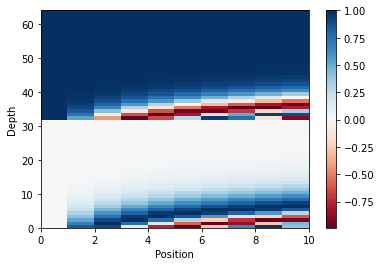

In [11]:
from matplotlib import pyplot as plt
n, d = 10, 64
pos_encoding = positional_encoding(n, d)
print(pos_encoding.shape)
pos_encoding = pos_encoding[0]

# Juggle the dimensions for the plot
pos_encoding = tf.reshape(pos_encoding, (n, d//2, 2))
pos_encoding = tf.transpose(pos_encoding, (2, 1, 0))
pos_encoding = tf.reshape(pos_encoding, (d, n))

plt.pcolormesh(pos_encoding, cmap='RdBu')
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar()
plt.show()

# Generator

[Multi-Head Attention](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MultiHeadAttention) 
and [Positional Encoding](https://www.tensorflow.org/text/tutorials/transformer)
based on [Vaswani+17, Attention is All You Need](https://arxiv.org/abs/1706.03762)

In [14]:
def Transformer(q_que_pad, k_que_pad, wv_dim, k_wv_dim, rate = 0.1, mask = ''):
    # Inputs
    mem  = Input((q_que_pad, wv_dim))
    encode = Input((k_que_pad, k_wv_dim))
    # Constants
    ff_dim = wv_dim*16
    # Multi-Head Attention
    q = Dense(wv_dim)(mem)
    k = Dense(wv_dim)(encode)
    v = Dense(wv_dim)(encode)
    # Choose a mask, default: BERT (no mask)
    mask_weights = np.ones((q_que_pad, k_que_pad))
    if mask == 'GPT':
        mask_weights = np.tri(q_que_pad, k_que_pad, 0)
    mem_new = MultiHeadAttention(
        num_heads = 4,
        key_dim = wv_dim, 
        value_dim = wv_dim
    )(
        q, k, v,
        attention_mask = mask_weights
    )
    mem_new = Dropout(rate)(mem_new)
    mem_new = LayerNormalization(epsilon=1e-6)(mem_new+mem)
    # Feed-Forward skip-connection
    ffn = Dense(ff_dim, activation = 'relu')(mem_new)
    ffn = Dense(wv_dim)(ffn)
    ffn = Dropout(rate)(ffn)
    out = LayerNormalization(epsilon=1e-6)(ffn+mem_new)
    model = Model(
        [mem, encode],
        [mem_new, out],
    )
    return model

def getE(wv_dim = 64):
    _input = Input((encoder_que_pad,))
    emb = Embedding(
        num_encoder_words, 
        wv_dim, 
        mask_zero = False,
        input_length=(int(encoder_que_pad)),
        trainable = True,
        #embeddings_initializer=tf.keras.initializers.Constant(encoder_emb32),
    )
    mem = emb(_input)
    # position encoding
    pe = positional_encoding(encoder_que_pad, wv_dim)
    mem = LayerNormalization(epsilon=1e-6)(mem+pe)
    # forward sentence
    for i in range(1):
        gptLayer = Transformer(encoder_que_pad, encoder_que_pad, wv_dim, wv_dim)
        mem, output = gptLayer((mem, mem))
        output = Activation('relu')(output)
        mem = Activation('relu')(mem)
    # Output
    model = Model(
        _input, 
        output) 
    return model

def getD(wv_dim = 64, encoder_wv_dim = 64):
    en_output = Input((encoder_que_pad, encoder_wv_dim))
    de_input  = Input((decoder_que_pad,))
    emb = Embedding(
        num_decoder_words, 
        wv_dim, 
        mask_zero = False,
        input_length=(int(decoder_que_pad)),
        trainable = True,
        #embeddings_initializer=tf.keras.initializers.Constant(decoder_emb32),
    )
    mem = emb(de_input)
    # position encoding
    pe = positional_encoding(decoder_que_pad, wv_dim)
    mem = LayerNormalization(epsilon=1e-6)(mem+pe)
    # Attention
    for j in range(1):
        # Self attention
        for i in range(1):
            gptLayer = Transformer(decoder_que_pad, decoder_que_pad, wv_dim, wv_dim, mask = 'GPT')
            mem, _ = gptLayer((mem, mem))
            mem = Activation('relu')(mem)
        # Cross attention
        for i in range(1):
            gptLayer = Transformer(decoder_que_pad, encoder_que_pad, wv_dim, encoder_wv_dim)
            mem, output = gptLayer((mem, en_output))
            output = Activation('relu')(output)
            mem = Activation('relu')(mem)
    # Concatenation and output
    output = Dense(num_decoder_words)(output)
    output = Activation('softmax')(output)
    model = Model(
        [en_output, de_input], 
        output,
    )
    return model

# Language Model
def getLM():
    # Inputs
    en_input = Input((encoder_que_pad,))
    de_input = Input((decoder_que_pad,))
    # Encoder (Chinese -> code)
    encoder = getE(encoder_wv_dim)
    encoder.summary()
    en_output = encoder(en_input)
    # Decoder (code -> English)
    decoder = getD(decoder_wv_dim, encoder_wv_dim)
    decoder.summary()
    de_output = decoder([en_output, de_input])
    # Establish the model
    model = Model(
        [en_input, de_input],
        de_output,
    )
    return model

In [15]:
mleG = getLM()
mleG.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=Adam(),
    metrics=['accuracy'],
)
mleG.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           [(None, 65)]         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 65, 64)       301824      input_14[0][0]                   
__________________________________________________________________________________________________
tf.__operators__.add_8 (TFOpLam (None, 65, 64)       0           embedding_2[0][0]                
__________________________________________________________________________________________________
layer_normalization_8 (LayerNor (None, 65, 64)       128         tf.__operators__.add_8[0][0]     
____________________________________________________________________________________________

In [ ]:
mleG.fit(
    [encoder_train, decoder_train], 
    teacher_train, 
    batch_size=128, 
    epochs=300, 
    shuffle=True, 
    validation_data = (
        [encoder_vali, decoder_vali], 
        teacher_vali
    ), 
    callbacks=[
        ModelCheckpoint(
            f'./{folder_name}/mleG.h5', 
            save_best_only=True, 
            monitor = "val_loss"
        ),
        EarlyStopping(monitor='val_loss', patience=5),
        CSVLogger(f'{folder_name}/mleG.csv'),
    ]
)

Epoch 1/300
1727/1727 [==============================] - 72s 40ms/step - loss: 1.2835 - accuracy: 0.6418 - val_loss: 0.9372 - val_accuracy: 0.7184
Epoch 2/300
1727/1727 [==============================] - 69s 40ms/step - loss: 0.9077 - accuracy: 0.7263 - val_loss: 0.8112 - val_accuracy: 0.7540
Epoch 3/300
1727/1727 [==============================] - 69s 40ms/step - loss: 0.8310 - accuracy: 0.7484 - val_loss: 0.7535 - val_accuracy: 0.7707
Epoch 4/300
1727/1727 [==============================] - 69s 40ms/step - loss: 0.7913 - accuracy: 0.7601 - val_loss: 0.7188 - val_accuracy: 0.7809
Epoch 5/300
1727/1727 [==============================] - 69s 40ms/step - loss: 0.7646 - accuracy: 0.7682 - val_loss: 0.6984 - val_accuracy: 0.7872
Epoch 6/300
1727/1727 [==============================] - 69s 40ms/step - loss: 0.7444 - accuracy: 0.7746 - val_loss: 0.6776 - val_accuracy: 0.7939
Epoch 7/300
1727/1727 [==============================] - 69s 40ms/step - loss: 0.7284 - accuracy: 0.7798 - val_loss: 0

In [18]:
mleG.load_weights(f'./{folder_name}/mleG.h5')
loss, _acc = mleG.evaluate(
    [encoder_vali, decoder_vali], 
    teacher_vali
)
print(loss)

768/768 [==============================] - 5s 6ms/step - loss: 0.6425 - accuracy: 0.8094
0.6425310969352722


No handles with labels found to put in legend.


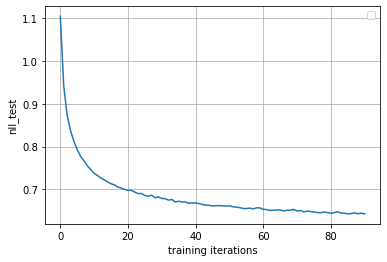

In [19]:
import csv
from matplotlib import pyplot as plt
%matplotlib inline
rows = csv.reader(open(f'{folder_name}/mleG.csv'))
nll_mle = []
for i, row in enumerate(rows):
    if i == 0:
        continue
    nll_mle.append(float(row[-1]))
plt.plot(nll_mle, )
plt.grid(True)
plt.ylabel('nll_test')
plt.xlabel('training iterations')
plt.legend()
plt.show()

## Inference train D (False) 

In [20]:
def inference(
    model,
    enData = None,
):
    # Initialize
    resp_pred_list = None
    in_batch_list = None
    the_first = True
    
    in_batch = np.zeros((len(enData), decoder_que_pad), dtype = int)
    in_batch[:,0] = decoder_word2idx['<bos>']
    en_batch = enData
    resp_pred = np.zeros(in_batch.shape, dtype = int)
    # Generate the sequence recurrsively.
    for i in range(decoder_que_pad):
        # Run
        resp_pred_wv = model([en_batch, in_batch])
        the_last = resp_pred_wv[:,i]
        # Stochastic
        the_last_one = tf.reshape(
            tf.random.categorical(tf.math.log(the_last), 1), 
            [len(enData),]
        )
        # TODO: greedy
        the_last_two = tf.math.argmax(the_last, axis = 1)
        try:
            resp_pred[:,i] = the_last_one
            in_batch[:,i+1] = the_last_one
        except:
            resp_pred[:,i] = the_last_one
    # Remove the words after <eos>
    for i in range(len(resp_pred)):
        try:
            index = list(resp_pred[i]).index(en_word2idx['<eos>'])
        except:
            continue
        resp_pred[i,index+1:] = 0
        in_batch[i,index+1:] = 0
        
    return resp_pred, in_batch

In [21]:
resp_pred_list, _ = inference(mleG, [encoder_vali[123]])
print('# Predicted sequence')
print(seq2word(resp_pred_list, decoder_idx2word))
print('# Real sequence')
print(seq2word([decoder_vali[123]], decoder_idx2word))

# Predicted sequence
['For far the FEU wey, suspecially War important.<eos>                                                                                                                                                               ']
# Real sequence
['<bos>The coming year will be particularly important for Europe.<eos>                                                                                                                                                   ']


# Step 2: Slow MLE

In [22]:
mleG = getLM()
mleG.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=Adam(learning_rate = 1e-5),
    metrics=['accuracy'],
)
mleG.summary()

Model: "model_16"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_31 (InputLayer)           [(None, 65)]         0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 65, 32)       150912      input_31[0][0]                   
__________________________________________________________________________________________________
tf.__operators__.add_22 (TFOpLa (None, 65, 32)       0           embedding_4[0][0]                
__________________________________________________________________________________________________
layer_normalization_22 (LayerNo (None, 65, 32)       64          tf.__operators__.add_22[0][0]    
___________________________________________________________________________________________

In [23]:
mleG.load_weights(f'./{folder_name}/mleG.h5')
loss, _acc = mleG.evaluate(
    [encoder_vali, decoder_vali], 
    teacher_vali
)
print(loss)

768/768 [==============================] - 7s 7ms/step - loss: 0.6425 - accuracy: 0.8094
0.6425310373306274


In [24]:
mleG.fit(
    [encoder_train, decoder_train], 
    teacher_train, 
    batch_size=128, 
    epochs=300, 
    shuffle=True, 
    validation_data = (
        [encoder_vali, decoder_vali], 
        teacher_vali
    ), 
    callbacks=[
        ModelCheckpoint(
            f'./{folder_name}/slowmleG.h5', 
            save_best_only=True, 
            monitor = "val_loss"
        ),
        EarlyStopping(monitor='val_loss', patience=5),
        CSVLogger(f'{folder_name}/slowmleG.csv'),
    ]
)

Epoch 1/300
1727/1727 [==============================] - 55s 30ms/step - loss: 0.7000 - accuracy: 0.7935 - val_loss: 0.6346 - val_accuracy: 0.8115
Epoch 2/300
1727/1727 [==============================] - 56s 32ms/step - loss: 0.6981 - accuracy: 0.7940 - val_loss: 0.6340 - val_accuracy: 0.8116
Epoch 3/300
1727/1727 [==============================] - 52s 30ms/step - loss: 0.6974 - accuracy: 0.7943 - val_loss: 0.6336 - val_accuracy: 0.8118
Epoch 4/300
1727/1727 [==============================] - 57s 33ms/step - loss: 0.6971 - accuracy: 0.7943 - val_loss: 0.6330 - val_accuracy: 0.8119
Epoch 5/300
1727/1727 [==============================] - 60s 35ms/step - loss: 0.6969 - accuracy: 0.7944 - val_loss: 0.6330 - val_accuracy: 0.8119
Epoch 6/300
1727/1727 [==============================] - 48s 28ms/step - loss: 0.6967 - accuracy: 0.7945 - val_loss: 0.6328 - val_accuracy: 0.8120
Epoch 7/300
1727/1727 [==============================] - 48s 28ms/step - loss: 0.6965 - accuracy: 0.7945 - val_loss: 0

KeyboardInterrupt: 

No handles with labels found to put in legend.


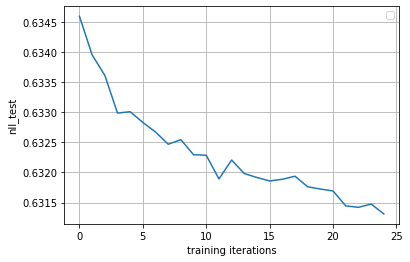

In [18]:
import csv
from matplotlib import pyplot as plt
%matplotlib inline
rows = csv.reader(open(f'{folder_name}/slowmleG.csv'))
nll_mle = []
for i, row in enumerate(rows):
    if i == 0:
        continue
    nll_mle.append(float(row[-1]))
plt.plot(nll_mle, )
plt.grid(True)
plt.ylabel('nll_test')
plt.xlabel('training iterations')
plt.legend()
plt.show()

In [ ]:
mleG.load_weights(f'./{folder_name}/slowmleG.h5')
loss, _acc = mleG.evaluate(
    [encoder_vali, decoder_vali], 
    teacher_vali
)
print(loss)

In [ ]:
resp_pred_list, _ = inference(mleG, [encoder_vali[123]])
print('# Predicted sequence')
print(seq2word(resp_pred_list, decoder_idx2word))
print('# Real sequence')
print(seq2word([decoder_vali[123]], decoder_idx2word))